In [73]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
def read_data_function():
    ticker= "^GSPC"
    start_date = "2020-01-01"
    stop_date = "2025-01-01"
    data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
    data_frame = pd.DataFrame(data_frame)
    return data_frame

In [49]:
read_data_function()

/tmp/ipython-input-1012245395.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000


In [50]:
def data_prep_function(sequence_dataset, window_size):
    for i in range(1, window_size + 1):
        sequence_dataset[f"Open-{i}"] = sequence_dataset["Open"].shift(i)

    sequence_dataset = sequence_dataset.drop(["Close", "High","Low", "Volume"], axis = 1)
    sequence_dataset.dropna(inplace = True)
    return sequence_dataset

In [51]:
def feature_target_modeling(dataset, window_size):
    X = dataset[:, 1:]
    y = dataset[:,0]
    X = np.flip(X, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)
    X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [52]:
class CustomLSTMDataSet(TensorDataset):
    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)

        return X,y

In [53]:
def split_groups(X_train, X_test, y_train, y_test):
    train_dataset = CustomLSTMDataSet(X_train, y_train)
    test_dataset = CustomLSTMDataSet(X_test, y_test)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_sub, val_sub = random_split(train_dataset, [train_size, val_size])
    val_loader = torch.utils.data.DataLoader(val_sub, batch_size=16, shuffle=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = False)
    return train_loader, val_loader, test_loader

In [54]:
import math
import torch.nn as nn
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz = 1):
        super().__init__()
        self.input_sz= input_sz
        self.hidden_size= hidden_sz
        self.W= nn.Parameter(torch.Tensor(input_sz, hidden_sz* 4))
        self.U= nn.Parameter(torch.Tensor(hidden_sz, hidden_sz* 4))
        self.bias= nn.Parameter(torch.Tensor(hidden_sz* 4))
        self.linear = nn.Linear(hidden_sz, output_sz)
        self.init_weights()

    def init_weights(self):
        stdv= 1.0/ math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x,
                init_states=None):


        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _= x.size()
        hidden_seq= []
        if init_states is None:

            h_t, c_t= (torch.zeros(bs, self.hidden_size).to(x.device),
                            torch.zeros(bs, self.hidden_size).to(x.device))
        else:

             h_t, c_t= init_states

        HS= self.hidden_size
        for t in range(seq_sz):
                        x_t= x[:, t, :]
            # batch the computations into a single matrix multiplication
                        gates= x_t@ self.W+ h_t@ self.U+ self.bias
                        i_t, f_t, g_t, o_t= (
                            torch.sigmoid(gates[:, :HS]),# input
                            torch.sigmoid(gates[:, HS:HS*2]),# forget
                            torch.tanh(gates[:, HS*2:HS*3]),
                            torch.sigmoid(gates[:, HS*3:]),# output
                        )
                        c_t= f_t* c_t+ i_t* g_t
                        h_t= o_t* torch.tanh(c_t)
                        hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq= torch.cat(hidden_seq, dim=0)
            # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq= hidden_seq.transpose(0, 1).contiguous()
        output = self.linear(hidden_seq[:, -1, :])
        return output

In [55]:
def train_model(model: torch.nn.Module, train_dataloader : DataLoader,val_dataloader: DataLoader, epochs: int):
    model.train(True)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_function = torch.nn.MSELoss()
    loss_vectorize_train = np.zeros(epochs)
    loss_vectorize_val = np.zeros(epochs)

    for epoch in range(epochs):
        epoch_loss_train = 0
        for batch_idx_train, act_batch_train in enumerate(train_dataloader):
            X_trained, y_trained = act_batch_train[0], act_batch_train[1]
            optimizer.zero_grad()
            preds = model(X_trained)
            loss = loss_function(preds, y_trained)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            loss_vectorize_train[epoch] = epoch_loss_train / len(train_dataloader)

        model.eval()

        with torch.no_grad():
            epoch_loss_val = 0
            for batch_idx_val, act_batch_val in enumerate(val_dataloader):
                X_validated, y_validated = act_batch_val[0], act_batch_val[1]
                preds_2 = model(X_validated)
                loss = loss_function(preds_2, y_validated)
                epoch_loss_val += loss.item()
                loss_vectorize_val[epoch] = epoch_loss_val / len(val_dataloader)

        print(f"Epoch {epoch}: Train loss {loss_vectorize_train[epoch] : .6f} || Val loss {loss_vectorize_val[epoch] : .6f}")



    return loss_vectorize_train, loss_vectorize_val, model

In [56]:

data = read_data_function()
window_data_10 = data_prep_function(data, 10)
window_data_10 = window_data_10.to_numpy()
scaler = MinMaxScaler()
normalized_data_10 = scaler.fit_transform(window_data_10)
X_train_10, X_test_10, y_train_10, y_test_10 = feature_target_modeling(normalized_data_10,10)
train_loader_10, val_loader_10, test_loader_10 = split_groups(X_train_10, X_test_10, y_train_10, y_test_10)
model_10 = CustomLSTM(1, 8)


/tmp/ipython-input-1012245395.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [57]:
loss_train_10, loss_val_10, model_10 = train_model(model_10, train_loader_10, val_loader_10,4)

Epoch 0: Train loss  0.072732 || Val loss  0.048756
Epoch 1: Train loss  0.034666 || Val loss  0.035905
Epoch 2: Train loss  0.017279 || Val loss  0.009537
Epoch 3: Train loss  0.002550 || Val loss  0.003312


In [58]:
test_predictions_10 = model_10(X_test_10).detach().numpy().flatten()

final_var_10 = np.zeros((X_test_10.shape[0], 11))
final_var_10[:, 0] = test_predictions_10
final_var_10 = scaler.inverse_transform(final_var_10)

test_predictions_10 = final_var_10[:, 0]
test_predictions_10

array([3900.8702898 , 4309.82659047, 3697.69347231, 4203.46685433,
       4671.78525971, 4022.05996803, 4163.01754431, 4672.9654699 ,
       4199.71544769, 3778.06605777, 5664.20052909, 5730.57756045,
       4645.65649739, 4255.12736875, 3573.75962994, 4297.89951717,
       4047.24691673, 4335.40362207, 4834.87387119, 4769.19867209,
       5915.24253324, 3669.99724688, 3955.67444676, 3317.13511614,
       4200.38558431, 3425.16668464, 3432.43993085, 4039.33443717,
       5943.05320261, 3938.49936612, 3884.62298613, 5157.5355937 ,
       4314.09757938, 4088.73063695, 4006.15792055, 3263.03392343,
       3701.74361046, 5309.07181974, 4283.14836141, 3269.21457528,
       4281.71209565, 4146.84812138, 3679.6544588 , 4069.28626094,
       3863.47519529, 3488.04723296, 4133.15865671, 3935.64336161,
       3738.54327953, 4447.4418604 , 4059.33665663, 4410.23999617,
       5945.54017919, 4700.85854797, 4669.77643466, 4105.92439538,
       4072.90386665, 3520.38573921, 4449.99449226, 3961.44826

In [59]:
final_var_10_2 = np.zeros((X_test_10.shape[0],11))
final_var_10_2[:, 0] = y_test_10.flatten()

final_var_10_2 = scaler.inverse_transform(final_var_10_2)

new_y_test_10 = final_var_10_2[:, 0]
new_y_test_10

/tmp/ipython-input-758020394.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_10_2[:, 0] = y_test_10.flatten()


array([3974.12991848, 4337.3599229 , 3771.96996538, 4462.39994348,
       4678.4800603 , 4153.47024837, 4224.60989082, 4753.92001014,
       4181.18017085, 3857.45992682, 5702.62992059, 5520.08017968,
       4689.29982341, 4493.1001242 , 3552.57006876, 4386.74989676,
       4096.62013717, 4415.95019401, 4892.95026447, 4655.33974503,
       5722.43019348, 3690.40992502, 3996.6298684 , 2813.47996576,
       4288.14019997, 3270.44991326, 3289.9198722 , 3963.89992087,
       5985.74996066, 3835.12015312, 3963.34003984, 5132.37988785,
       4406.85988143, 4201.94002957, 4110.29001845, 2869.09009784,
       3694.0300211 , 5167.87992205, 4409.58004744, 2939.50000454,
       4369.02002904, 4228.56007447, 3705.97996055, 4087.77999383,
       3915.80007319, 3238.93996528, 4229.33978747, 3890.90993161,
       3803.13992092, 4532.41993708, 4084.72996666, 4480.02000841,
       5819.68014686, 4778.1402415 , 4640.2498986 , 4198.1001015 ,
       4128.41993056, 3411.2299939 , 4554.85977847, 3938.67991

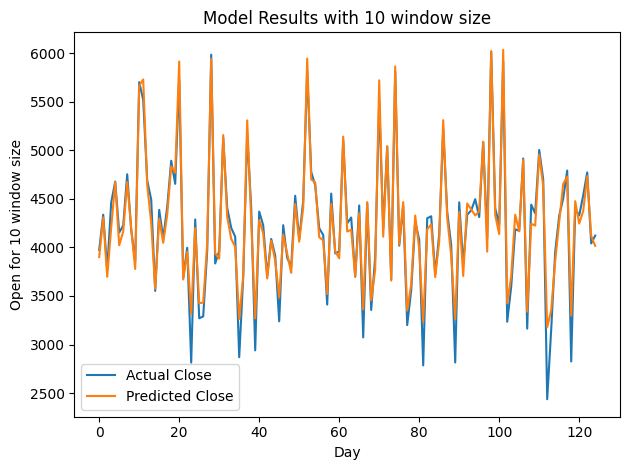

In [60]:
plt.plot(new_y_test_10, label='Actual Close')
plt.plot(test_predictions_10, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 10 window size')
plt.legend()
plt.title("Model Results with 10 window size")
plt.tight_layout()
plt.show()

In [61]:
data_20 = read_data_function()
window_data_20 = data_prep_function(data_20, 20)
window_data_20 = window_data_20.to_numpy()
scaler_20 = MinMaxScaler()
normalized_data_20 = scaler_20.fit_transform(window_data_20)
X_train_20, X_test_20, y_train_20, y_test_20 = feature_target_modeling(normalized_data_20,20)
train_loader_20, val_loader_20, test_loader_20 = split_groups(X_train_20, X_test_20, y_train_20, y_test_20)
model_20 = CustomLSTM(1, 8)

/tmp/ipython-input-1012245395.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [62]:
loss_train_20, loss_val_20, model_20 = train_model(model_20, train_loader_20, val_loader_20,4)

Epoch 0: Train loss  0.149025 || Val loss  0.065773
Epoch 1: Train loss  0.033734 || Val loss  0.017543
Epoch 2: Train loss  0.012053 || Val loss  0.002619
Epoch 3: Train loss  0.001925 || Val loss  0.001112


In [63]:

test_predictions_20 = model_20(X_test_20).detach().numpy().flatten()

final_var_20 = np.zeros((X_test_20.shape[0], 21))
final_var_20[:, 0] = test_predictions_20
final_var_20 = scaler_20.inverse_transform(final_var_20)

test_predictions_20 = final_var_20[:, 0]
test_predictions_20

array([4460.11106472, 3198.39268173, 5617.84926253, 4429.57004144,
       3805.10142889, 3853.81458741, 4918.99254294, 3324.35912089,
       4057.79579522, 3819.90114692, 3453.83019341, 4103.43900359,
       3790.17922982, 4305.29049008, 4320.19763372, 5713.76528182,
       3551.12735067, 3777.37543218, 5220.60450473, 5893.08025519,
       3753.33994119, 4766.74927749, 5252.10907578, 4390.03447174,
       4615.66380888, 5333.21756633, 4540.0909637 , 3782.11653551,
       3955.07404058, 3879.60669664, 3765.07853856, 3886.25768931,
       5303.10488713, 5066.90142818, 5261.76877808, 3939.77364447,
       3425.73947033, 4406.14084296, 3360.2842164 , 4221.31105279,
       3479.57872113, 5555.3880024 , 4297.53365881, 4395.90858138,
       3634.24704344, 4398.14131356, 4170.33980557, 3916.1260856 ,
       5827.89769705, 5614.37994718, 3925.59063324, 3955.82941585,
       5212.60339055, 4158.16414782, 3857.51392262, 4742.65379116,
       5487.98606953, 3470.72771071, 5617.77341937, 3807.27473

In [64]:
final_var_20_2 = np.zeros((X_test_20.shape[0],11))
final_var_20_2[:, 0] = y_test_20.flatten()

final_var_20_2 = scaler.inverse_transform(final_var_20_2)

new_y_test_20 = final_var_20_2[:, 0]
new_y_test_20

/tmp/ipython-input-2136389547.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_20_2[:, 0] = y_test_20.flatten()


array([4562.83983769, 2812.63991783, 5520.08017968, 4341.74026181,
       3840.36012335, 3953.50001193, 4957.189877  , 3199.91990269,
       4157.68022315, 3911.64986735, 3367.27005098, 4216.52002882,
       3825.09006451, 4202.66020003, 4401.30997302, 5737.79986722,
       3371.87984375, 3858.85012069, 5154.76992179, 6057.5897374 ,
       3816.21992351, 4690.5699134 , 5242.47993715, 4462.12011617,
       4670.25979333, 5340.25966068, 4336.1899006 , 3778.05009674,
       3940.72994753, 4001.73999966, 3840.27001714, 4034.43994953,
       5204.29007421, 5100.91991711, 5219.52006069, 3996.6298684 ,
       3235.65991824, 4362.41012751, 3225.97995337, 4152.93017712,
       3508.34003362, 5584.24032669, 4367.48007321, 4426.02986368,
       3668.28002181, 4312.87978721, 4308.31991508, 3853.79002328,
       5914.33988639, 5615.20992043, 3929.59005835, 4037.12015638,
       5019.87979861, 4224.60989082, 3951.42994635, 4588.02972956,
       5351.87996536, 3434.27997656, 5655.50980811, 3853.29002

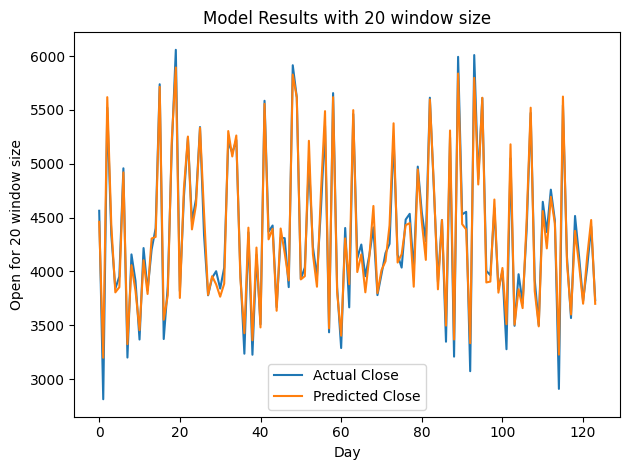

In [65]:
plt.plot(new_y_test_20, label='Actual Close')
plt.plot(test_predictions_20, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 20 window size')
plt.legend()
plt.title("Model Results with 20 window size")
plt.tight_layout()
plt.show()

In [66]:
data_50 = read_data_function()
window_data_50 = data_prep_function(data_50, 50)
window_data_50 = window_data_50.to_numpy()
scaler_50 = MinMaxScaler()
normalized_data_50 = scaler_50.fit_transform(window_data_50)
X_train_50, X_test_50, y_train_50, y_test_50 = feature_target_modeling(normalized_data_50,50)
train_loader_50, val_loader_50, test_loader_50 = split_groups(X_train_50, X_test_50, y_train_50, y_test_50)
model_50 = CustomLSTM(1, 8)

/tmp/ipython-input-1012245395.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [67]:
loss_train_50, loss_val_50, model_50 = train_model(model_50, train_loader_50, val_loader_50,4)

Epoch 0: Train loss  0.120977 || Val loss  0.025465
Epoch 1: Train loss  0.019041 || Val loss  0.010577
Epoch 2: Train loss  0.005503 || Val loss  0.001238
Epoch 3: Train loss  0.001314 || Val loss  0.000798


In [68]:

test_predictions_50 = model_50(X_test_50).detach().numpy().flatten()

final_var_50 = np.zeros((X_test_50.shape[0], 51))
final_var_50[:, 0] = test_predictions_50
final_var_50 = scaler_50.inverse_transform(final_var_50)

test_predictions_50 = final_var_50[:, 0]
test_predictions_50

array([4137.38696969, 4440.87067285, 5642.02761036, 5575.250761  ,
       3941.64153708, 5942.83903057, 3465.81443208, 4462.39745311,
       4153.61412398, 3179.20051253, 3117.15355983, 4566.3671108 ,
       3473.39591849, 4488.38584897, 4368.63651166, 3935.50073118,
       5306.62468912, 3857.80382462, 4447.82786814, 3809.23442852,
       4212.45325046, 4276.60320957, 4289.0079816 , 5803.41212782,
       3692.42995675, 4579.54457751, 4415.77677352, 5636.62825629,
       4250.12171994, 3551.86936849, 4001.58106862, 3908.93898364,
       4787.8176028 , 5922.22938661, 4106.16143357, 4042.56558234,
       5322.23955136, 3378.07430586, 3515.19512364, 3581.3640957 ,
       4471.73431256, 5207.16011537, 4101.57269576, 3886.02721665,
       3836.06977745, 5237.10729798, 3839.24715322, 4354.34969718,
       3249.73273048, 5558.22272554, 3382.00547211, 4527.37240473,
       4082.10669878, 5750.61532433, 4337.36626203, 4114.60606046,
       5752.69682298, 3919.84092904, 3894.93992038, 3331.27556

In [69]:
final_var_50_2 = np.zeros((X_test_50.shape[0],51))
final_var_50_2[:, 0] = y_test_50.flatten()

final_var_50_2 = scaler_50.inverse_transform(final_var_50_2)

new_y_test_50 = final_var_50_2[:, 0]
new_y_test_50

/tmp/ipython-input-4143826222.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_50_2[:, 0] = y_test_50.flatten()


array([4201.94002957, 4521.77970719, 5623.89022713, 5602.49022947,
       4151.08979181, 6074.28994927, 3360.47993704, 4473.26996683,
       4282.99033595, 2508.59009356, 2436.50000609, 4491.58009136,
       3320.11009254, 4546.99993633, 4363.14003307, 4075.57003685,
       5305.35007118, 3960.60006405, 4310.62011372, 3791.8400819 ,
       4201.27011935, 4469.10017761, 4396.10984876, 5857.81974955,
       3666.40986523, 4699.2597288 , 4282.62991113, 5490.50972251,
       4128.16987452, 3371.87984375, 3940.72994753, 3815.11012294,
       4655.33974503, 5919.74014605, 4087.77999383, 4153.47024837,
       5244.04977744, 3219.84010966, 3407.73000169, 3612.09008573,
       4445.12988909, 5103.77977038, 4166.79000591, 3966.38984061,
       3888.57011341, 5139.08985707, 3932.35007032, 4403.58979589,
       3098.89992148, 5637.7699789 , 3231.75999484, 4494.14992942,
       4119.49998211, 5719.14018496, 4522.91010993, 4190.77976461,
       5751.79983607, 3939.20991469, 3913.13990252, 3225.97995

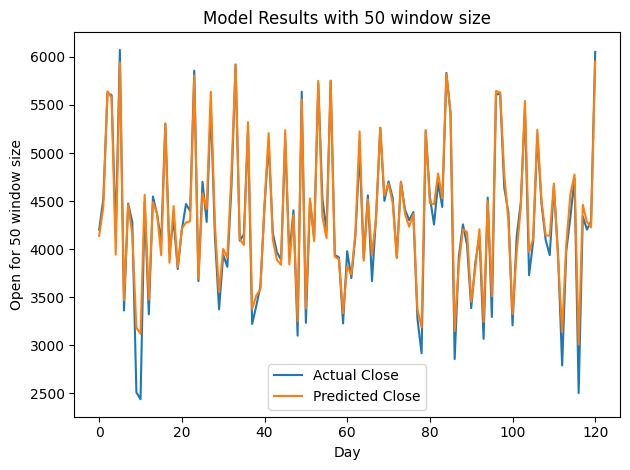

In [70]:
plt.plot(new_y_test_50, label='Actual Close')
plt.plot(test_predictions_50, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 50 window size')
plt.title("Model Results with 50 window size")
plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipython-input-1657143438.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
/tmp/ipython-input-1657143438.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,2].legend()
/tmp/ipython-input-1657143438.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,1].legend()
/tmp/ipython-input-1657143438.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,2].legend()
/tmp/ipython-input-1657143438.py:66: UserWarning: No artists with labels found to put in

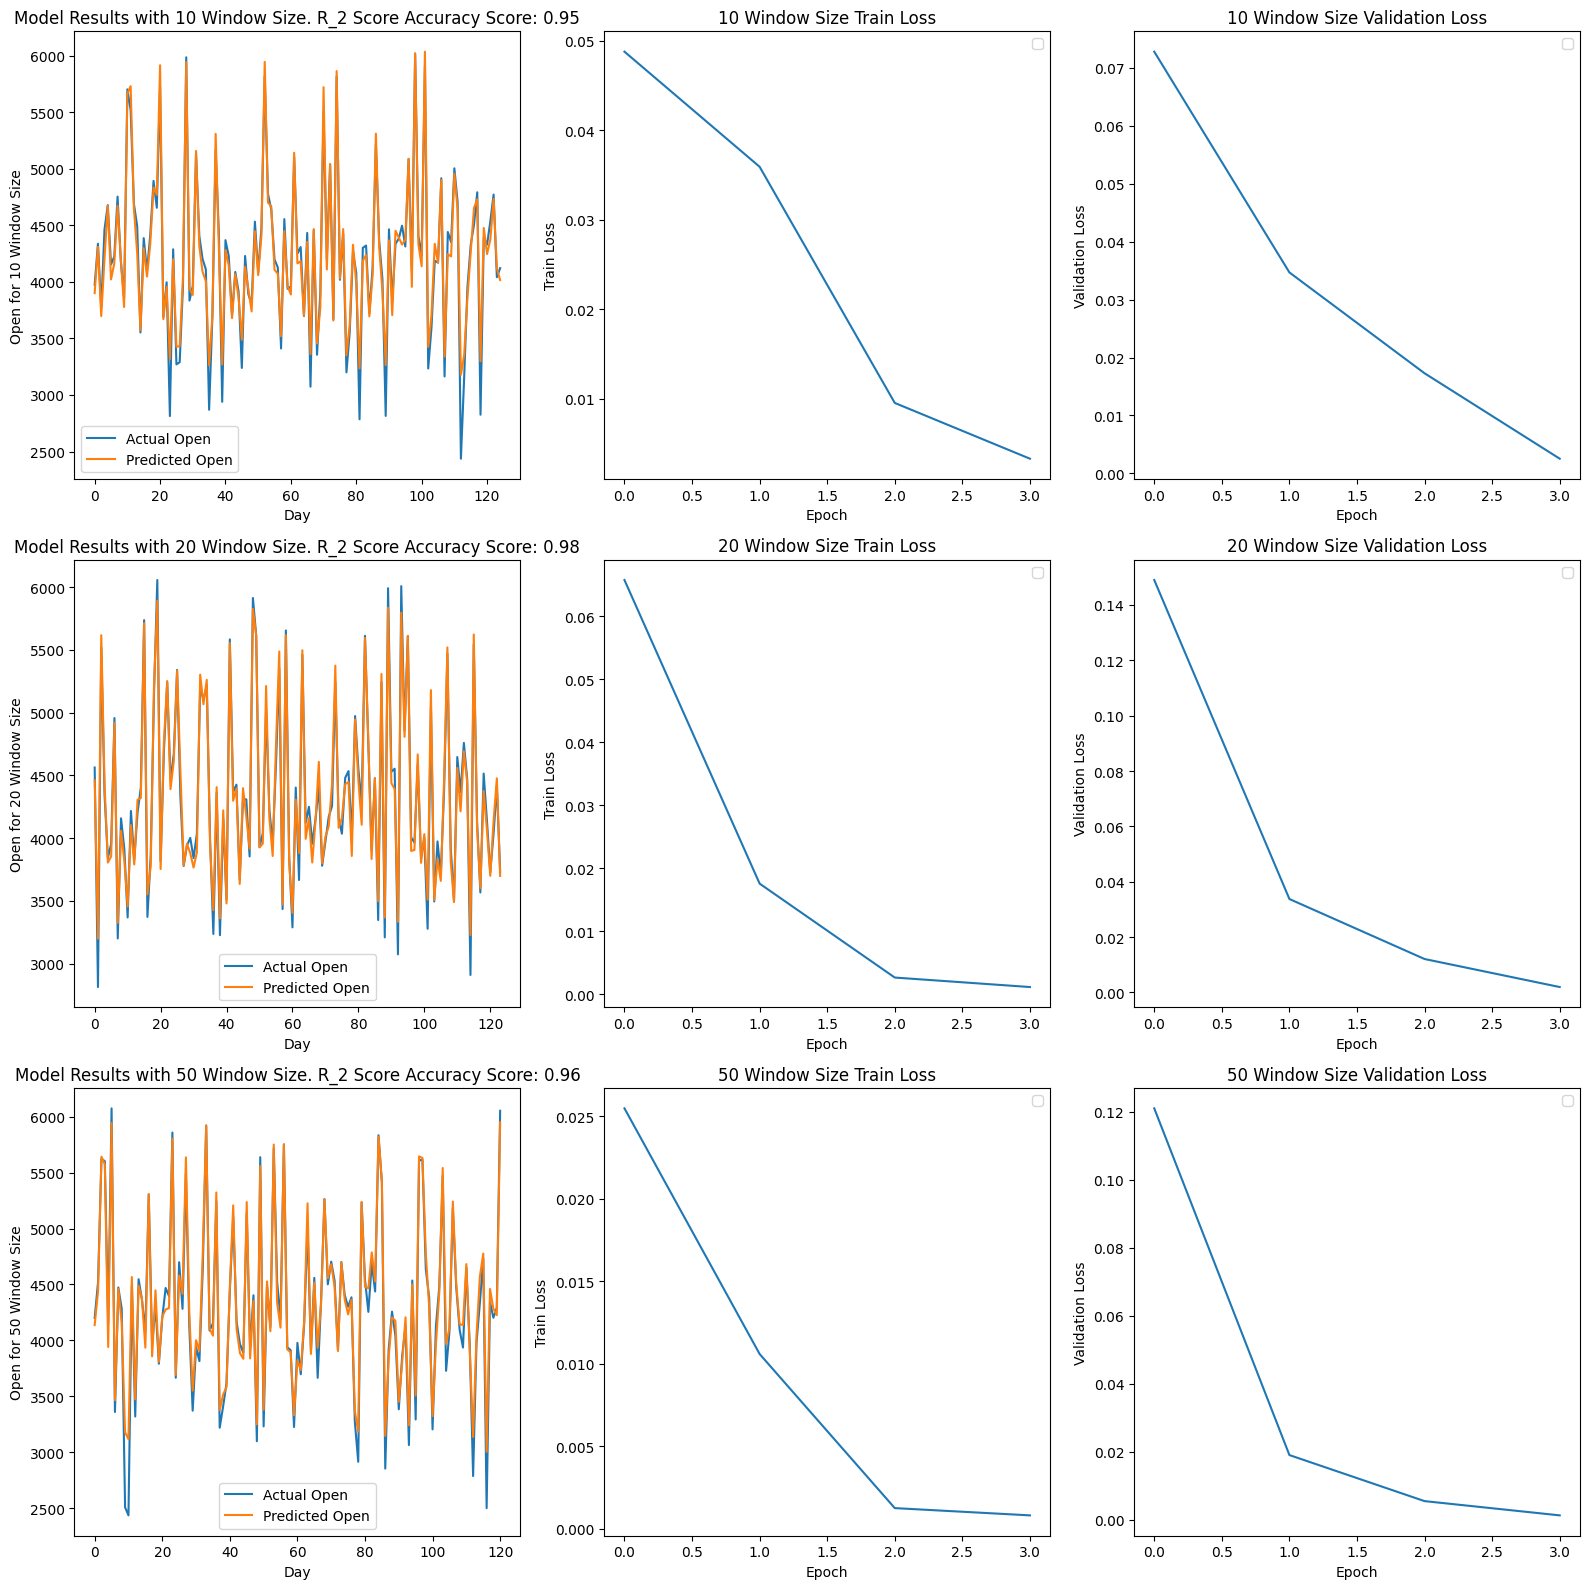

<Figure size 640x480 with 0 Axes>

In [76]:
predictions_10, actual_10, loss_vec_10_val, loss_vec_10_train = test_predictions_10, new_y_test_10, loss_train_10, loss_val_10
predictions_20, actual_20, loss_vec_20_val, loss_vec_20_train = test_predictions_20, new_y_test_20, loss_train_20, loss_val_20
predictions_50, actual_50, loss_vec_50_val, loss_vec_50_train = test_predictions_50, new_y_test_50, loss_train_50, loss_val_50

accuracy_10 = r2_score(actual_10, predictions_10)
accuracy_20 = r2_score(actual_20, predictions_20)
accuracy_50 = r2_score(actual_50, predictions_50)

fig, axes = plt.subplots(3,3, figsize = (16,16))

axes[0,0].plot(actual_10, label='Actual Open')
axes[0,0].plot(predictions_10, label='Predicted Open')
axes[0,0].set_title(f"Model Results with 10 Window Size. R_2 Score Accuracy Score: {accuracy_10:.2f}")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Open for 10 Window Size')
axes[0,0].legend()


axes[0,1].plot(loss_vec_10_train)
axes[0,1].set_title("10 Window Size Train Loss")
axes[0,1].set_xlabel("Epoch")
axes[0,1].set_ylabel("Train Loss")
axes[0,1].legend()


axes[0,2].plot(loss_vec_10_val)
axes[0,2].set_title("10 Window Size Validation Loss")
axes[0,2].set_xlabel("Epoch")
axes[0,2].set_ylabel("Validation Loss")
axes[0,2].legend()


axes[1,0].plot(actual_20, label='Actual Open')
axes[1,0].plot(predictions_20, label='Predicted Open')
axes[1,0].set_title(f"Model Results with 20 Window Size. R_2 Score Accuracy Score: {accuracy_20:.2f}")
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Open for 20 Window Size')
axes[1,0].legend()


axes[1,1].plot(loss_vec_20_train)
axes[1,1].set_title("20 Window Size Train Loss")
axes[1,1].set_xlabel("Epoch")
axes[1,1].set_ylabel("Train Loss")
axes[1,1].legend()


axes[1,2].plot(loss_vec_20_val)
axes[1,2].set_title("20 Window Size Validation Loss")
axes[1,2].set_xlabel("Epoch")
axes[1,2].set_ylabel("Validation Loss")
axes[1,2].legend()

axes[2,0].plot(actual_50, label='Actual Open')
axes[2,0].plot(predictions_50, label='Predicted Open')
axes[2,0].set_title(f"Model Results with 50 Window Size. R_2 Score Accuracy Score: {accuracy_50:.2f}")
axes[2,0].set_xlabel('Day')
axes[2,0].set_ylabel('Open for 50 Window Size')
axes[2,0].legend()


axes[2,1].plot(loss_vec_50_train)
axes[2,1].set_title("50 Window Size Train Loss")
axes[2,1].set_xlabel("Epoch")
axes[2,1].set_ylabel("Train Loss")
axes[2,1].legend()


axes[2,2].plot(loss_vec_50_val)
axes[2,2].set_title("50 Window Size Validation Loss")
axes[2,2].set_xlabel("Epoch")
axes[2,2].set_ylabel("Validation Loss")
axes[2,2].legend()

plt.tight_layout()
plt.show()
plt.savefig("results.png")




